# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156070
##### Wiktoria Szarzyńska : 156058

In [59]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import PIL
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

### Defining dataset class

In [60]:
import cv2

class ApplyCLAHE:
    """
    Konwersja RGB → YUV, zastosowanie CLAHE na kanale Y, powrót do RGB.
    """
    def __init__(self, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img: PIL.Image.Image) -> PIL.Image.Image:
        # Konwersja PIL.Image → numpy (RGB, uint8)
        img_np = np.array(img)
        # RGB → YUV
        img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
        # CLAHE na kanale Y
        y_channel = img_yuv[:, :, 0]
        img_yuv[:, :, 0] = self.clahe.apply(y_channel)
        # YUV → RGB
        img_rgb_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return PIL.Image.fromarray(img_rgb_eq)


class Blur3x3:
    """
    Gaussian Blur z kernelem 3×3 (OpenCV).
    """
    def __call__(self, img: PIL.Image.Image) -> PIL.Image.Image:
        img_np = np.array(img)
        blurred = cv2.GaussianBlur(img_np, ksize=(3, 3), sigmaX=0)
        return PIL.Image.fromarray(blurred)


class AddGaussianNoise:
    """
    Dodaje gaussowski szum do tensora (po ToTensor).
    """
    def __init__(self, mean: float = 0.0, std: float = 0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [61]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor([forward, left], dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
def get_transforms(augument=True):
    """Create transformations for training and validation"""
    common_transforms = [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]

    preprocessing = [
        ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
        Blur3x3(),
    ]

    if augument:
        augmentations = [
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.05),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=10),
            AddGaussianNoise(mean=0.0, std=0.02),
        ]
        return transforms.Compose(preprocessing + augmentations + common_transforms)
    else:
        return transforms.Compose(preprocessing + common_transforms)



In [62]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_samples_per_folder(dataset):
    folder_counts = defaultdict(int)
    for img_path, _, _ in dataset.samples:
        folder = os.path.basename(os.path.dirname(img_path))
        folder_counts[folder] += 1
    
    folders = list(folder_counts.keys())
    counts = [folder_counts[f] for f in folders]
    
    plt.figure(figsize=(12, 6))
    plt.bar(folders, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Samples per Folder")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()


def show_sample_images(dataset, num=9):
    indices = np.random.choice(len(dataset), num, replace=False)
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img, (fwd, left) = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Fwd: {fwd:.2f}, Left: {left:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def plot_target_distributions(dataset):
    forward_vals = [s[1] for s in dataset.samples]
    left_vals = [s[2] for s in dataset.samples]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(forward_vals, bins=50, color='skyblue')
    plt.title("Forward Distribution")
    plt.xlabel("Forward")
    
    plt.subplot(1, 3, 2)
    plt.hist(left_vals, bins=50, color='salmon')
    plt.title("Left Distribution")
    plt.xlabel("Left")

    plt.subplot(1, 3, 3)
    plt.scatter(forward_vals, left_vals, alpha=0.3, s=5)
    plt.title("Forward vs Left")
    plt.xlabel("Forward")
    plt.ylabel("Left")

    plt.tight_layout()
    plt.show()



Loaded 7584 samples from 13 folders


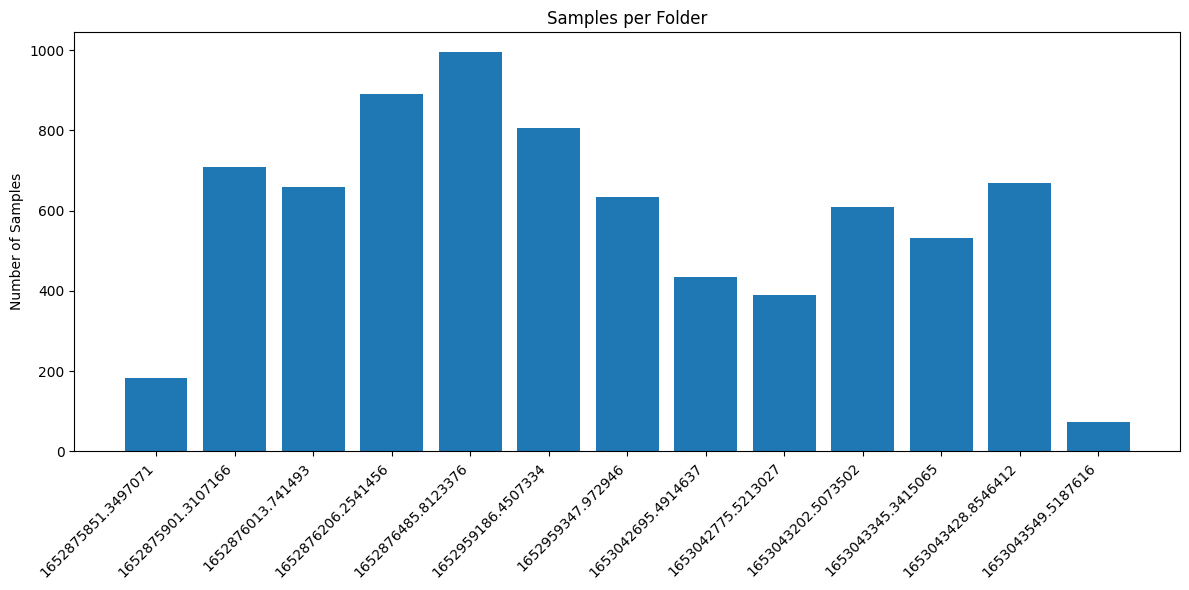

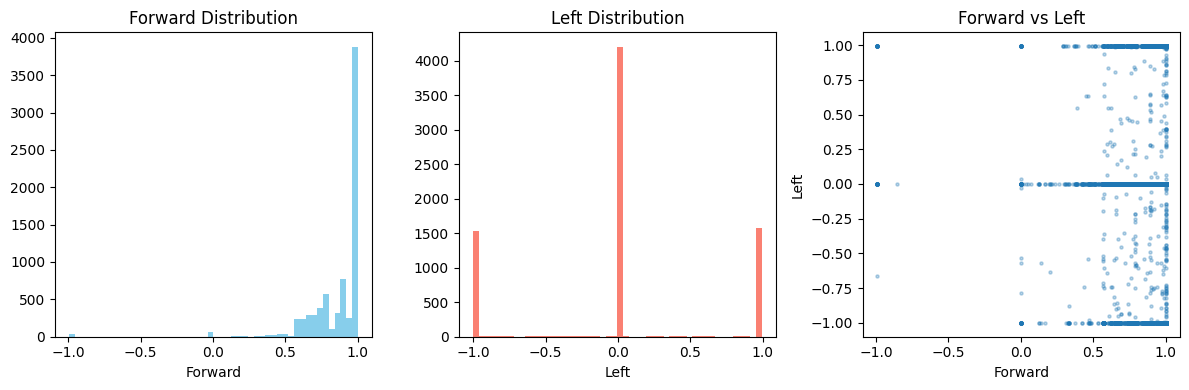

In [63]:
train_dataset = JetBotDataset(root_dir="../dataset", transform=None)

plot_samples_per_folder(train_dataset)
plot_target_distributions(train_dataset)
# show_sample_images(train_dataset, num=9)


### Dividing dataset to train, test, validation

In [64]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Get transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset with dummy transform (we'll override it in subsets)
    full_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(full_dataset)

    # Compute lengths
    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

    # Assign transforms manually (they use the same dataset class)
    train_set.dataset.transform = train_transform
    val_set.dataset.transform = val_test_transform
    test_set.dataset.transform = val_test_transform

    # Optionally return DataLoaders
    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }


### Divide to train and test

In [65]:
# from torch.utils.data import random_split

# generator = torch.Generator().manual_seed(44)
# num_test = int(len(dataset) * 0.2)
# train_dataset, test_dataset = random_split(dataset, [len(dataset) - num_test, num_test], generator= generator)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [66]:
# data = create_datasets(root_dir = "put_jetbot_dataset/dataset/", batch_size=8)
# train_loader = data["train"]
# val_loader = data["val"]
# test_loader = data["test"]


## Displaying dataset

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to unnormalize using ImageNet stats
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Show a batch of images from DataLoader
def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Unnormalize all images in the batch
    unnorm_images = unnormalize(images.clone())

    # Create a grid and display
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=5)
    npimg = img_grid.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(npimg)
    plt.axis("off")

    # Show the [forward, left] labels
    print("Labels (forward, left):")
    for i in range(min(5, labels.size(0))):  # show up to 5 labels
        print(f"{i+1}. {labels[i].tolist()}")

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images[0], labels[0])
# # Example usage (assuming train_loader exists)
# show_batch(train_loader)


### Resnet transfer learning

In [68]:
# model = models.resnet18(pretrained=True)
# model.fc = torch.nn.Linear(512,2)
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True
# device = torch.device('cpu')
# model = model.to(device)

### Train model to 2 output: forward, left
> Horrible, training takes too long, we're ditching this approach

In [69]:
# import torch.nn.functional as functional
# import torch.optim as optim


# epochs = 70
# best_model_path = 'best_model_jetbot.pth'
# best_loss = 1e9
# optimizer = optim.Adam(model.parameters())

# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
    
#     for images, targets in iter(train_loader):
#         images = images.to(device)
#         targets = targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = functional.mse_loss(outputs, targets)
#         train_loss += float(loss)
#         loss.backward()
#         optimizer.step()
#     train_loss /= len(train_loader)
    
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for images, targets in iter(test_loader):
#             images = images.to(device)
#             targets = targets.to(device)
#             outputs = model(images)
#             loss = functional.mse_loss(outputs, targets)      
#             test_loss += float(loss)
#     test_loss /= len(test_loader)
        
#     print(f"Train: {train_loss} -- Test: {test_loss}")
#     if test_loss < best_loss:
#         torch.save(model.state_dict(), best_model_path)
#         best_loss = test_loss
        

###  Nvidia paper CNN


In [70]:
class NvidiaPaperNetwork(nn.Module):
    """implementation of nvidia's end-to-end self driving cars network"""
    def __init__(self):
        super(NvidiaPaperNetwork, self).__init__()
        
        
        self.conv1a = nn.Conv2d(3, 12, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        
        self.conv2a = nn.Conv2d(12, 18, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        
        self.conv3a = nn.Conv2d(18, 24, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        # 224 -> 112 -> 56 -> 28 -> 14 -> 14 after all conv layers
        feature_size = 32 *14*14  #32 channels of 28x28
        self.fc1 = nn.Linear(feature_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.output = nn.Linear(10, 2)  # Output of 2 values: forward, left
        
    def forward(self, x):
        
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        x = x.view(x.size(0), -1)  #Flatten the output 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        
        return x
    

### CustomJetBotCNN

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomJetBotCNN(nn.Module):
    """
    Prosty CNN do regresji (2 wartości: forward i left):
      – Conv2d(3 → 64, kernel 3×3, padding=1) → ReLU → MaxPool2d(2×2)
      – Conv2d(64 → 32, kernel 3×3, padding=1) → ReLU → MaxPool2d(2×2)
      – Conv2d(32 → 64, kernel 3×3, padding=1) → ReLU → MaxPool2d(2×2)
      – Flatten
      – Linear(64*28*28 → 128) → ReLU
      – Linear(128 → 64) → ReLU
      – Linear(64 → 32) → ReLU
      – Linear(32 → 2) → Tanh
    """
    def __init__(self):
      super(CustomJetBotCNN, self).__init__()
      # Konwolucje + pool
      self.conv1 = nn.Conv2d(in_channels=3,  out_channels=64, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

      # Po trzech poolingu: 224→112→56→28, kanały=64 → feat_size = 64*28*28
      feat_size = 4096 #64 * 28 * 28

      # Warstwy w pełni połączone
      self.fc1 = nn.Linear(feat_size, 128)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(128, 64)
      self.dropout2 = nn.Dropout(0.3)
      self.fc3 = nn.Linear(64, 32)

      # Wyjście regresyjne (2 wartości) + aktywacja Tanh
      self.fc_out = nn.Linear(32, 2)
      self.act_out = nn.Tanh()

    def forward(self, x):
      # 1) Conv1 + ReLU + Pool
      x = F.relu(self.conv1(x))  # → [B,64,224,224]
      x = self.pool(x)           # → [B,64,112,112]

      # 2) Conv2 + ReLU + Pool
      x = F.relu(self.conv2(x))  # → [B,32,112,112]
      x = self.pool(x)           # → [B,32,56,56]

      # 3) Conv3 + ReLU + Pool
      x = F.relu(self.conv3(x))  # → [B,64,56,56]
      x = self.pool(x)           # → [B,64,28,28]

      # 4) Flatten
      x = x.view(x.size(0), -1)  # → [B, 64*28*28] = [B, 4096]

      # 5) Warstwy gęste ze ReLU i dropout
      x = F.relu(self.fc1(x))    # → [B,128]
      x = self.dropout1(x)
      x = F.relu(self.fc2(x))    # → [B,64]
      x = self.dropout2(x)
      x = F.relu(self.fc3(x))    # → [B,32]

      # 6) Wyjście regresyjne → Tanh
      x = self.fc_out(x)         # → [B,2]
      x = self.act_out(x)        # → [B,2], obie wartości w [–1,1]

      return x


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CustomJetBotCNN().to(device)

Using device: cuda


In [73]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
CustomJetBotCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=2, bias=True)
  (act_out): Tanh()
)

Total parameters: 573,570


In [74]:
def training(model, train_loader, val_loader, device, epochs=70):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 7
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = F.mse_loss(outputs, targets)
            
            train_loss += float(loss)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = F.mse_loss(outputs, targets)      
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [75]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and visualise predictions
    """
    
    model.eval()
    all_targets = []
    all_predictions = []
    test_loss = 0.0
    
    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc=f"Evaluating")

        for images, targets in test_iterator:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            
            loss = F.mse_loss(outputs, targets)
            test_loss += float(loss)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
            
            test_iterator.set_postfix(loss=float(loss))
            
        test_loss /= len(test_loader)
        print(f"Final test loss: {test_loss:.6f}")  
        
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    # Calculate Mean Absolute Error for each output dimension
    mae = np.mean(np.abs(all_predictions - all_targets), axis=0)
    print(f"Mean Absolute Error per output: {mae}")
    
    # Visualize predictions vs targets (assuming 2D outputs, e.g., x, y coordinates)
    if all_predictions.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(all_targets[:, 0], all_targets[:, 1], c='blue', alpha=0.5, label='Ground Truth')
        plt.scatter(all_predictions[:, 0], all_predictions[:, 1], c='red', alpha=0.5, label='Predictions')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Predictions vs Ground Truth')
        plt.legend()
        plt.grid(True)
        plt.savefig('predictions_vs_ground_truth.png')
        plt.show()
    
    return test_loss, mae

Using device: cuda
Loaded 7584 samples from 13 folders
CustomJetBotCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=2, bias=True)
  (act_out): Tanh()
)
Total parameters: 573,570


Epoch 1/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.37it/s, loss=0.0108]


Epoch 1/70 - Train loss: 0.201775 - Val loss: 0.103606
New best model saved with val loss: 0.103606


Epoch 2/70 [Test]: 100%|██████████| 143/143 [00:02<00:00, 54.42it/s, loss=0.00793]


Epoch 2/70 - Train loss: 0.120134 - Val loss: 0.092252
New best model saved with val loss: 0.092252


Epoch 3/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 47.36it/s, loss=0.00764]


Epoch 3/70 - Train loss: 0.108087 - Val loss: 0.092715


Epoch 4/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.65it/s, loss=0.00611]


Epoch 4/70 - Train loss: 0.100048 - Val loss: 0.086157
New best model saved with val loss: 0.086157


Epoch 5/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 47.22it/s, loss=0.00436]


Epoch 5/70 - Train loss: 0.095713 - Val loss: 0.082595
New best model saved with val loss: 0.082595


Epoch 6/70 [Test]: 100%|██████████| 143/143 [00:02<00:00, 47.79it/s, loss=0.00623]


Epoch 6/70 - Train loss: 0.091483 - Val loss: 0.082066
New best model saved with val loss: 0.082066


Epoch 7/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.95it/s, loss=0.00531]


Epoch 7/70 - Train loss: 0.083799 - Val loss: 0.082012
New best model saved with val loss: 0.082012


Epoch 8/70 [Test]: 100%|██████████| 143/143 [00:02<00:00, 48.63it/s, loss=0.00522]


Epoch 8/70 - Train loss: 0.081560 - Val loss: 0.076695
New best model saved with val loss: 0.076695


Epoch 9/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.97it/s, loss=0.00362]


Epoch 9/70 - Train loss: 0.078470 - Val loss: 0.078843


Epoch 10/70 [Test]: 100%|██████████| 143/143 [00:02<00:00, 51.13it/s, loss=0.00195]


Epoch 10/70 - Train loss: 0.069207 - Val loss: 0.077042


Epoch 11/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.76it/s, loss=0.00562]


Epoch 11/70 - Train loss: 0.069283 - Val loss: 0.078505


Epoch 12/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 46.74it/s, loss=0.00364]


Epoch 12/70 - Train loss: 0.062523 - Val loss: 0.082701


Epoch 13/70 [Test]: 100%|██████████| 143/143 [00:02<00:00, 48.34it/s, loss=0.00265]


Epoch 13/70 - Train loss: 0.059701 - Val loss: 0.081330


Epoch 14/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 47.06it/s, loss=0.00275]


Epoch 14/70 - Train loss: 0.056152 - Val loss: 0.081322


Epoch 15/70 [Test]: 100%|██████████| 143/143 [00:03<00:00, 47.52it/s, loss=0.00239]


Epoch 15/70 - Train loss: 0.048145 - Val loss: 0.083676
Early stopping triggered at epoch 16.
Training completed. Best val loss: 0.076695


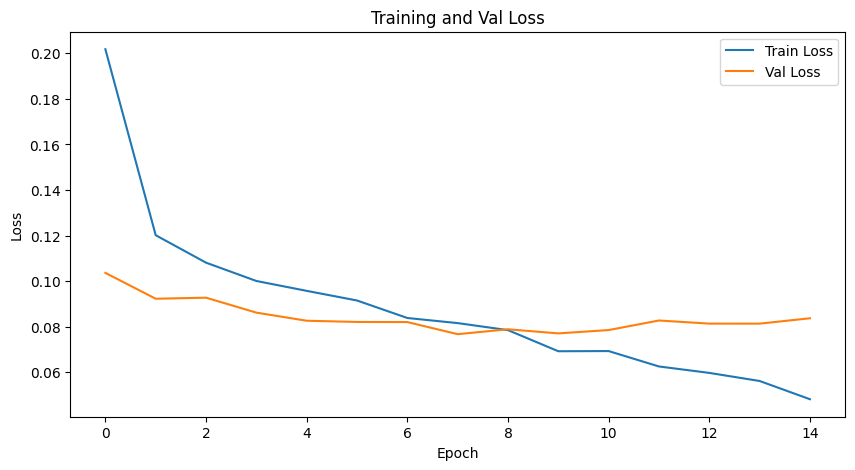

<All keys matched successfully>

In [76]:
root_dir = "../dataset/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = create_datasets(root_dir = "../dataset/", batch_size=8)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

# Create model and move to device
model = CustomJetBotCNN().to(device)

# Print model summary
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Train the model
best_model_path = training(model, train_loader, test_loader, device, epochs=70)

# Load the best model
model.load_state_dict(torch.load(best_model_path))


Evaluating: 100%|██████████| 143/143 [00:03<00:00, 45.80it/s, loss=0.00522]


Final test loss: 0.076695
Mean Absolute Error per output: [0.11366516 0.21424708]


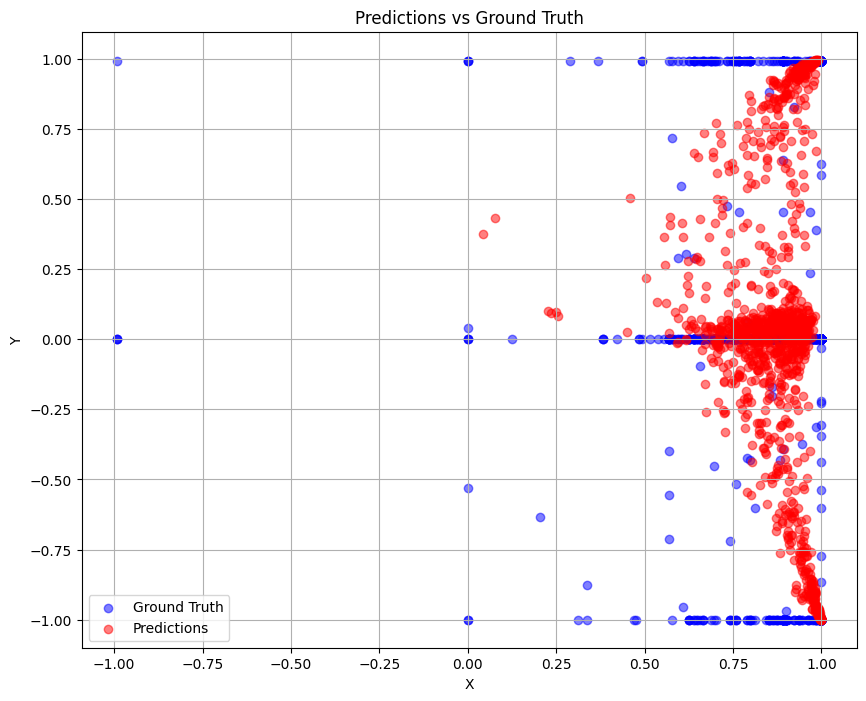

(0.07669531432846627, array([0.11366516, 0.21424708], dtype=float32))

In [77]:
# Evaluate the model
evaluate_model(model, test_loader, device)

## Exporting the model

In [79]:
model.eval()

import torch

# Assuming your model takes a (3, 224, 224) image as input
dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batch size of 1

import torch.onnx

# Path where the ONNX model will be saved
onnx_model_path = "model_jetbot.onnx"

# Exporting the model
torch.onnx.export(
    model,               # Model to export
    dummy_input,         # Example input tensor
    onnx_model_path,     # Path to save the ONNX file
    opset_version=11,    # Define the ONNX opset version
    input_names=["input"],       # Name of the input node
    output_names=["output"],     # Name of the output node
    dynamic_axes={
        "input": {0: "batch_size"},  # Dynamic batch size
        "output": {0: "batch_size"}  # Dynamic batch size
    },
    do_constant_folding=True,  # Enable constant folding optimization
    verbose=True              # Show detailed export info
)

import onnx

# Load the exported model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")



Model has been successfully exported to ONNX format!
